In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### **Load Bangle Data**

In [2]:
bangle_data = pd.read_csv("HRV-data/bangle.csv")
print(bangle_data.head())

    timestamp_ms  value
0  1724074011462   4334
1  1724074011481   4286
2  1724074011501   4222
3  1724074011520   4174
4  1724074011540   4094


### **Plot Unfiltered Bangle Data**

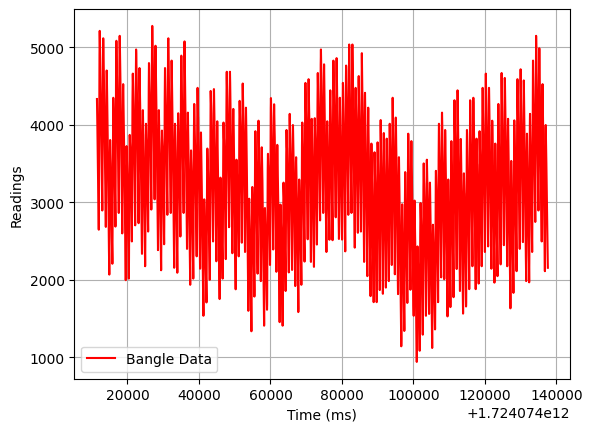

In [3]:
x_axis = bangle_data["timestamp_ms"]
y_axis = bangle_data["value"]

plt.plot(x_axis, y_axis, c='r', label="Bangle Data")
plt.legend()
plt.grid(True, 'both', 'both')
plt.xlabel("Time (ms)")
plt.ylabel("Readings")
plt.show()